/tmp/ipykernel_704/1011985754.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data= pd.read_csv("mw_r_v_sd.2", delim_whitespace=True, header=None, names=['x', 'y', 'error'])


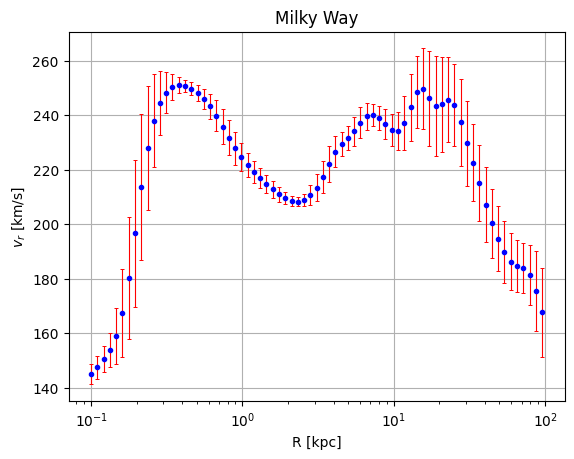

In [ ]:
import pandas as pd, matplotlib.pyplot as plt, numpy as np
data= pd.read_csv("mw_r_v_sd.2", delim_whitespace=True, header=None, names=['r', 'v', 'std'])
xl=data['r']
yl=data['v']
el=data['std']
plt.errorbar(xl, yl, el, fmt='.b', ecolor='red',elinewidth=0.8, capsize=1.5, capthick=0.7)
plt.xlabel('R [kpc]')
plt.ylabel('$v_r$ [km/s]')
plt.title('Milky Way')
xl= np.array(xl)
yl = np.array(yl)
el = np.array(el)
plt.xscale('log')                   # important line
plt.grid()
plt.show()

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import iv, kv , gammainc
from scipy.integrate import simpson

k=7.6695
G= 4.302e-6
def rho_bulge(r, a_b, sig_b):
    if r <= 0:
        raise ValueError(f"Invalid radius r={r} passed to rho_bulge()")
    theta= np.linspace(1e-6, np.pi /2, 801)                                                           # obtained after substitutions
    integrand_val= (np.sin(theta)**0.75) * np.exp(-k * ((r/(np.sin(theta) * a_b))**0.25 - 1))/(r**0.75)
    x_val= np.linspace( 0, np.pi/2, 801)
    integral = simpson(integrand_val, x_val)
    rho_val = (k * sig_b / (4 * np.pi * a_b**0.25)) * integral
    return rho_val

def v_bulge(r,a_b, sig_b):
    if r <= 0:
        return 0.0
    x_val= np.linspace(1e-6, r)
    rho_vals = np.array([rho_bulge(x, a_b, sig_b) for x in x_val])
    integrand_val= 4 * np.pi * x_val**2 * rho_vals
    mass = simpson(integrand_val ,x_val )   # avoid x=0 singularity
    return np.sqrt(G*mass/r)

In [13]:
rs = np.linspace(0.01, 100, 1000)
def v_disk(r,a_d, sig_d):
    if r <= 0:
        return 0.0
    v2= np.pi*G* sig_d* (r**2/a_d) *(iv(0,r/(2*a_d))*kv(0,r/(2*a_d)) - iv(1,r/(2*a_d))*kv(1,r/(2*a_d)))
    if v2>0:
        return np.sqrt(v2)
    return 0.0

In [14]:
def v_halo(r, rho, h):
    if r <= 0:
        return 0.0
    v2= G*2*np.pi*rho*h*r/(1+ (r/h))**2
    if v2>= 0:
        return np.sqrt(v2)
    return 0.0

/tmp/ipykernel_921/648679315.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data= pd.read_csv("mw_r_v_sd.2", delim_whitespace=True, header=None, names=['r', 'v', 'std'])


<ErrorbarContainer object of 3 artists>

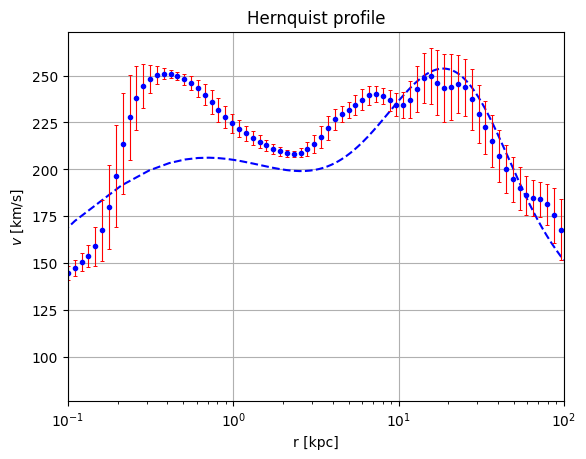

In [15]:
plt.plot(rs ,np.sqrt ([ v_bulge(r ,1.775 , 592000000)**2 + v_disk(r ,9.237, 552000000)**2 + v_halo(r , 63090, 142.324)**2 for r in rs ])  , color='blue',linestyle='--')
plt.xscale('log')
plt.xlabel("r [kpc]")
plt.ylabel("$v$ [km/s]")
plt.xlim(0.1, 100)
plt.title('Hernquist profile')
plt.yticks(range(100, 276, 25))
import pandas as pd, matplotlib.pyplot as plt, numpy as np
data= pd.read_csv("mw_r_v_sd.2", delim_whitespace=True, header=None, names=['r', 'v', 'std'])
xl=data['r']
yl=data['v']
el=data['std']
plt.grid()
plt.errorbar(xl, yl, el, fmt='.b', ecolor='red',elinewidth=0.8, capsize=1.5, capthick=0.7)

In [6]:
def ln_likeli(xl ,yl,el ,a_b, sig_b, a_d, sig_d, rho, h):
    vbulge = np.array([v_bulge(x, a_b, sig_b) for x in xl])
    vdisk  = np.array([v_disk(x, a_d, sig_d) for x in xl])
    vhalo  = np.array([v_halo(x, rho, h) for x in xl])

    vth = np.sqrt(vbulge**2 +vdisk**2 + vhalo**2)
    chi2 = np.sum((yl - vth)**2 / el**2)
    return -0.5 * chi2


In [7]:
# 
def ln_prior(theta):
      a_b, sig_b, a_d, sig_d, rho, h = theta
      if not (1.6 < a_b < 2):
          return -np.inf
      if not (0.525 < sig_b < 0.650):
          return -np.inf
      if not ( 8.5 < a_d < 10 ):
          return -np.inf
      if not (0.50 < sig_d < 0.60):
          return -np.inf
      if not (3 < rho < 8):
          return -np.inf
      if not ( 120< h < 160):
         return -np.inf
      return 0.0

In [8]:
def ln_post(theta, xl, yl, el):
    a_b, sig_b, a_d, sig_d, rho, h = theta
    lp = ln_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = ln_likeli(xl, yl, el, a_b, sig_b, a_d, sig_d, rho, h)
    if not np.isfinite(ll):
        return -np.inf
    return lp + ll

In [ ]:
print(type (np.random.normal(1, [0.04, 0.1, 0.15, 0.01, 0.3, 3])))

<class 'numpy.ndarray'>


In [9]:
# FOR CHECKING
import time
init_guess = [1.7, 0.6, 9, 0.55, 5.5, 130]  # Rough center of prior a_b, sig_b, a_d, sig_d, rho, h
for _ in range(5):
    theta = init_guess + np.random.normal(0, [0.05, 0.03, 0.3, 0.02, 0.5, 5])
    t0 = time.time()
    val = ln_post(theta, xl, yl, el)
    print(f"ln_pos = {val:.2f}, Time = {time.time() - t0:.4f} sec")

ln_pos = -87050.17, Time = 0.6721 sec
ln_pos = -87043.48, Time = 0.6091 sec
ln_pos = -87042.06, Time = 0.7124 sec
ln_pos = -87050.28, Time = 0.6804 sec
ln_pos = -87061.18, Time = 0.5834 sec


In [11]:
import emcee
import numpy as np
import pandas as pd
# ---- MCMC SETUP ----
ndim = 6           # No. of parameters
nwalkers = 200      # Number of independent chains ("walkers")
nsteps = 500      # Steps each walker takes
burnin = 200      # Discard these initial steps (they're still "warming up")

# ---- INITIAL GUESS FOR WALKERS ----
np.random.seed(21)
init_guess = [1.7, 0.6, 9, 0.55, 5.5, 130]  # Rough center of prior a_b, sig_b, a_d, sig_d, rho, h
pos =  np.array([init_guess] * nwalkers) + np.random.normal(0, [0.05, 0.03, 0.3, 0.02, 0.5, 5], (nwalkers, ndim))

In [12]:
import multiprocessing
import emcee
import numpy as np

if __name__ == '__main__':
    # --- CONFIG ---
    short_test_steps = 300     # small test run
    full_steps = 2000          # actual big run
    burnin = 500
    nwalkers = 200
    ndim = 6

    # -- your 'pos' init must already be here --

    print("Running short test to estimate autocorrelation time...")

    with multiprocessing.Pool(processes=6) as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_post, args=(xl, yl, el), pool=pool)
        sampler.run_mcmc(pos, short_test_steps, progress=True)

        try:
            tau = sampler.get_autocorr_time()
            print("Estimated autocorrelation times:", tau)
            print("→ Suggests minimum nsteps ≈", int(50 * np.max(tau)))
        except emcee.autocorr.AutocorrError as e:
            print("Autocorr not reliable yet:", e)
            tau = None

    # ✅ If satisfied, run full chain:
    print("\nStarting full run...")

    with multiprocessing.Pool(processes=6) as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_post, args=(xl, yl, el), pool=pool)
        sampler.run_mcmc(pos, full_steps, progress=True)

    flat_samples = sampler.get_chain(discard=burnin, flat=True)
    print("Shape of samples:", flat_samples.shape)


Running short test to estimate autocorrelation time...


  0%|          | 0/300 [00:00<?, ?it/s]/home/nina/code/dskc25/.venv/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 300/300 [58:54<00:00, 11.78s/it] 

Autocorr not reliable yet: The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 6;
tau: [27.66592966 26.59725499 27.303305   27.4367457  35.87687955 38.02073081]

Starting full run...



100%|██████████| 2000/2000 [6:21:15<00:00, 11.44s/it]  

Shape of samples: (300000, 6)


In [19]:
# import multiprocessing
# if __name__ == '__main__':
#     with multiprocessing.Pool(processes=6) as pool:
#         sampler = emcee.EnsembleSampler(
#             nwalkers,
#             ndim,
#             ln_post,
#             args=(xl, yl, el),
#             pool=pool
#         )
#         sampler.run_mcmc(pos, nsteps, progress=True)

#     flat_samples = sampler.get_chain(discard=burnin, flat=True)
#     print("Shape of samples:", flat_samples.shape)

In [20]:
ab_samp = flat_samples[:, 0]  # All sampled values of 
sb_samp = flat_samples[:, 1]  # All sampled values of 
ad_samp = flat_samples[:, 2]  # All sampled values of h0
sd_samp = flat_samples[:, 3]  # All sampled values of om
rho_samp= flat_samples[:, 4]
h_samp= flat_samples[:, 5]
# ---- SUMMARIZE RESULTS ----
print(f"a_b = {np.mean(ab_samp):.3f} ± {np.std(ab_samp):.3f}")
print(f"sigma_b = {np.mean(sb_samp):.3f} ± {np.std(sb_samp):.3f}")
print(f"a_d = {np.mean(ad_samp):.3f} ± {np.std(ad_samp):.3f}")
print(f"sigma_d = {np.mean(sd_samp):.3f} ± {np.std(sd_samp):.3f}")
print(f"rho_0 = {np.mean(rho_samp):.3f} ± {np.std(rho_samp):.3f}")
print(f"h = {np.mean(h_samp):.3f} ± {np.std(h_samp):.3f}")

a_b = 1.800 ± 0.116
sigma_b = 0.588 ± 0.036
a_d = 9.261 ± 0.432
sigma_d = 0.552 ± 0.029
rho_0 = 7.922 ± 0.078
h = 158.523 ± 1.450


In [21]:
print(flat_samples.shape)
print("Mean acceptance fraction:", np.mean(sampler.acceptance_fraction))
for _ in range(10):
    test = init_guess + np.random.normal(0, 1, 6)
    print(test, ln_post(test, xl, yl, el))


(300000, 6)
Mean acceptance fraction: nan
[ 9.36604027e-01  1.12614594e-01  9.28186972e+00 -1.03218738e+00
  4.02615105e+00  1.29771917e+02] -inf
[  2.19283246   1.00072783   8.34029961   0.4606953    5.76688687
 129.68732529] -inf
[ -0.24079819   0.68040162   9.0372956    0.35573499   5.85107495
 130.21661785] -inf
[  1.75845706   1.87597635   8.16420954   0.83634803   4.85253261
 128.82442203] -inf
[  2.74084904   0.88376115   9.45121309   1.61522712   6.57388058
 129.38833994] -inf
[-5.95263778e-01  4.86371856e-01  8.22767331e+00 -1.14745241e-01
  7.18697891e+00  1.29572124e+02] -inf
[  1.32272608   1.34294378   8.94577921  -0.23757266   7.48205237
 128.86281811] -inf
[  2.21340355   0.98351072  10.46501992  -0.45577008   5.61331907
 129.72384835] -inf
[  0.22271927   0.48996913   8.64276588   0.86794435   5.07112916
 129.688677  ] -inf
[  2.94368077   2.50940577   9.86624815   0.97571117   4.17049538
 129.25864165] -inf


In [22]:
np.any(np.isnan(flat_samples))
np.any(np.isinf(flat_samples))


np.False_

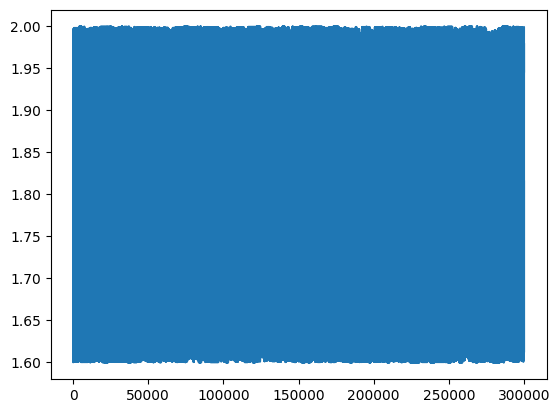

In [23]:
plt.plot(ab_samp)


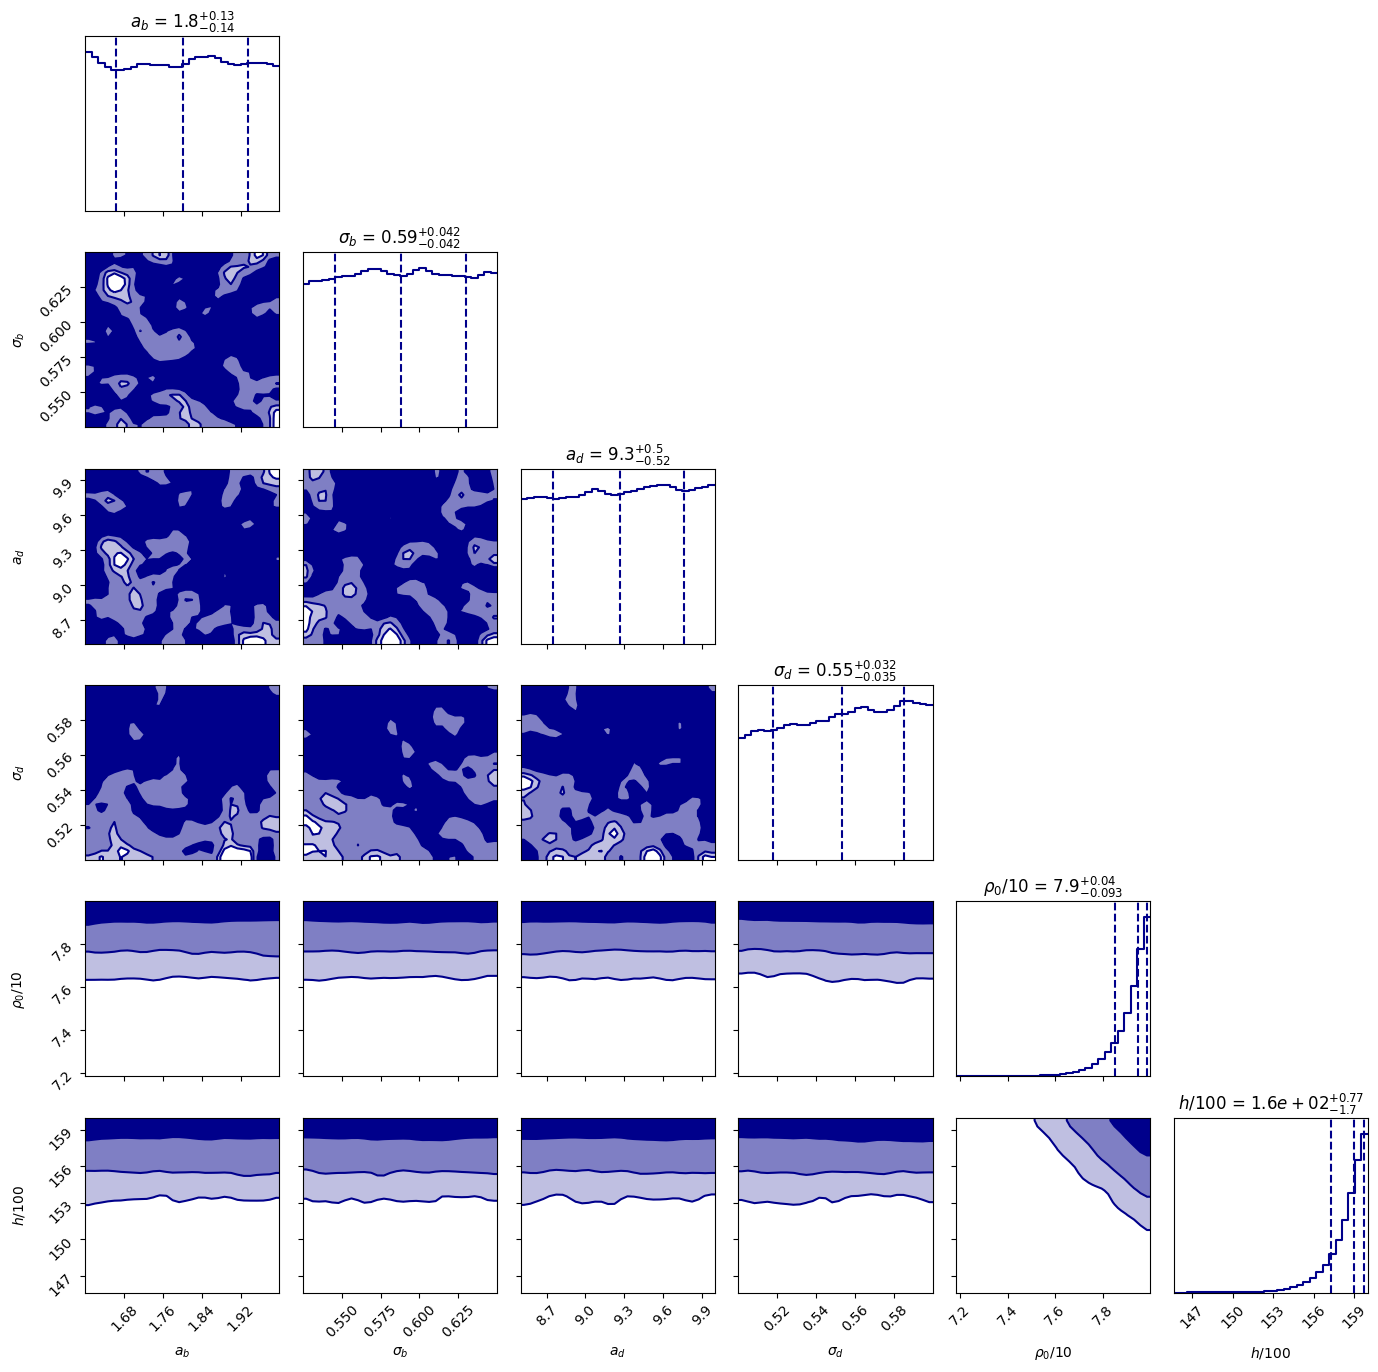

In [ ]:
import corner
# samples_scaled = np.copy(flat_samples)
# samples_scaled[:, 4] /= 10    # scale rho_0
# samples_scaled[:, 5] /= 100   # scale h

corner.corner(
    flat_samples,                                                                              # samples_scaled, in place of flat samples?
    labels=["$a_b$", "$\\sigma_b$", "$a_d$", "$\\sigma_d$", "$\\rho_0/10$", "$h/100$"],
    bins=30,
    color="darkblue",
    quantiles=[0.16, 0.5, 0.84],
    plot_contours=True,
    fill_contours=True,
    levels=(0.68, 0.95, 0.99),
    plot_datapoints=False,         # cleaner plots
    smooth=1.0, smooth1d=1.0,
    title_fmt=".2g",
    show_titles=True
)
plt.tight_layout()
plt.show()
# fig = corner.corner(flat_samples[::10],  # downsampling to reduce overplotting
#     labels=["$a_b$", "$\\sigma_b$", "$a_d$", "$\\sigma_d$", "$\\rho_0$", "$h$"],
#     bins=30,
#     color="darkblue",
#     quantiles=[0.16, 0.5, 0.84],
#     plot_contours=True,
#     fill_contours=True,
#     levels=(0.68, 0.95, 0.99),
#     plot_datapoints=False,         # cleaner plots
#     smooth=1.0, smooth1d=1.0,
#     title_fmt=".2g",
#     show_titles=True
# )


In [107]:
samples = sampler.get_chain(discard=burnin, flat=True)  
ab_samp = samples[:, 0]  # All sampled values of 
sb_samp = samples[:, 1]  # All sampled values of 
ad_samp = samples[:, 2]  # All sampled values of h0
sd_samp = samples[:, 3]  # All sampled values of om
rho_samp= samples[:, 4]
h_samp= samples[:, 5]
# ---- SUMMARIZE RESULTS ----
print(f"a_b = {np.mean(ab_samp):.3f} ± {np.std(ab_samp):.3f}")
print(f"sigma_b = {np.mean(sb_samp):.3f} ± {np.std(sb_samp):.3f}")
print(f"a_d = {np.mean(ad_samp):.3f} ± {np.std(ad_samp):.3f}")
print(f"sigma_d = {np.mean(sd_samp):.3f} ± {np.std(sd_samp):.3f}")
print(f"rho_0 = {np.mean(rho_samp):.3f} ± {np.std(rho_samp):.3f}")
print(f"h = {np.mean(h_samp):.3f} ± {np.std(h_samp):.3f}")

a_b = 1.799 ± 0.114
sigma_b = 0.591 ± 0.035
a_d = 9.288 ± 0.414
sigma_d = 0.550 ± 0.029
rho_0 = 7.885 ± 0.107
h = 157.880 ± 1.941


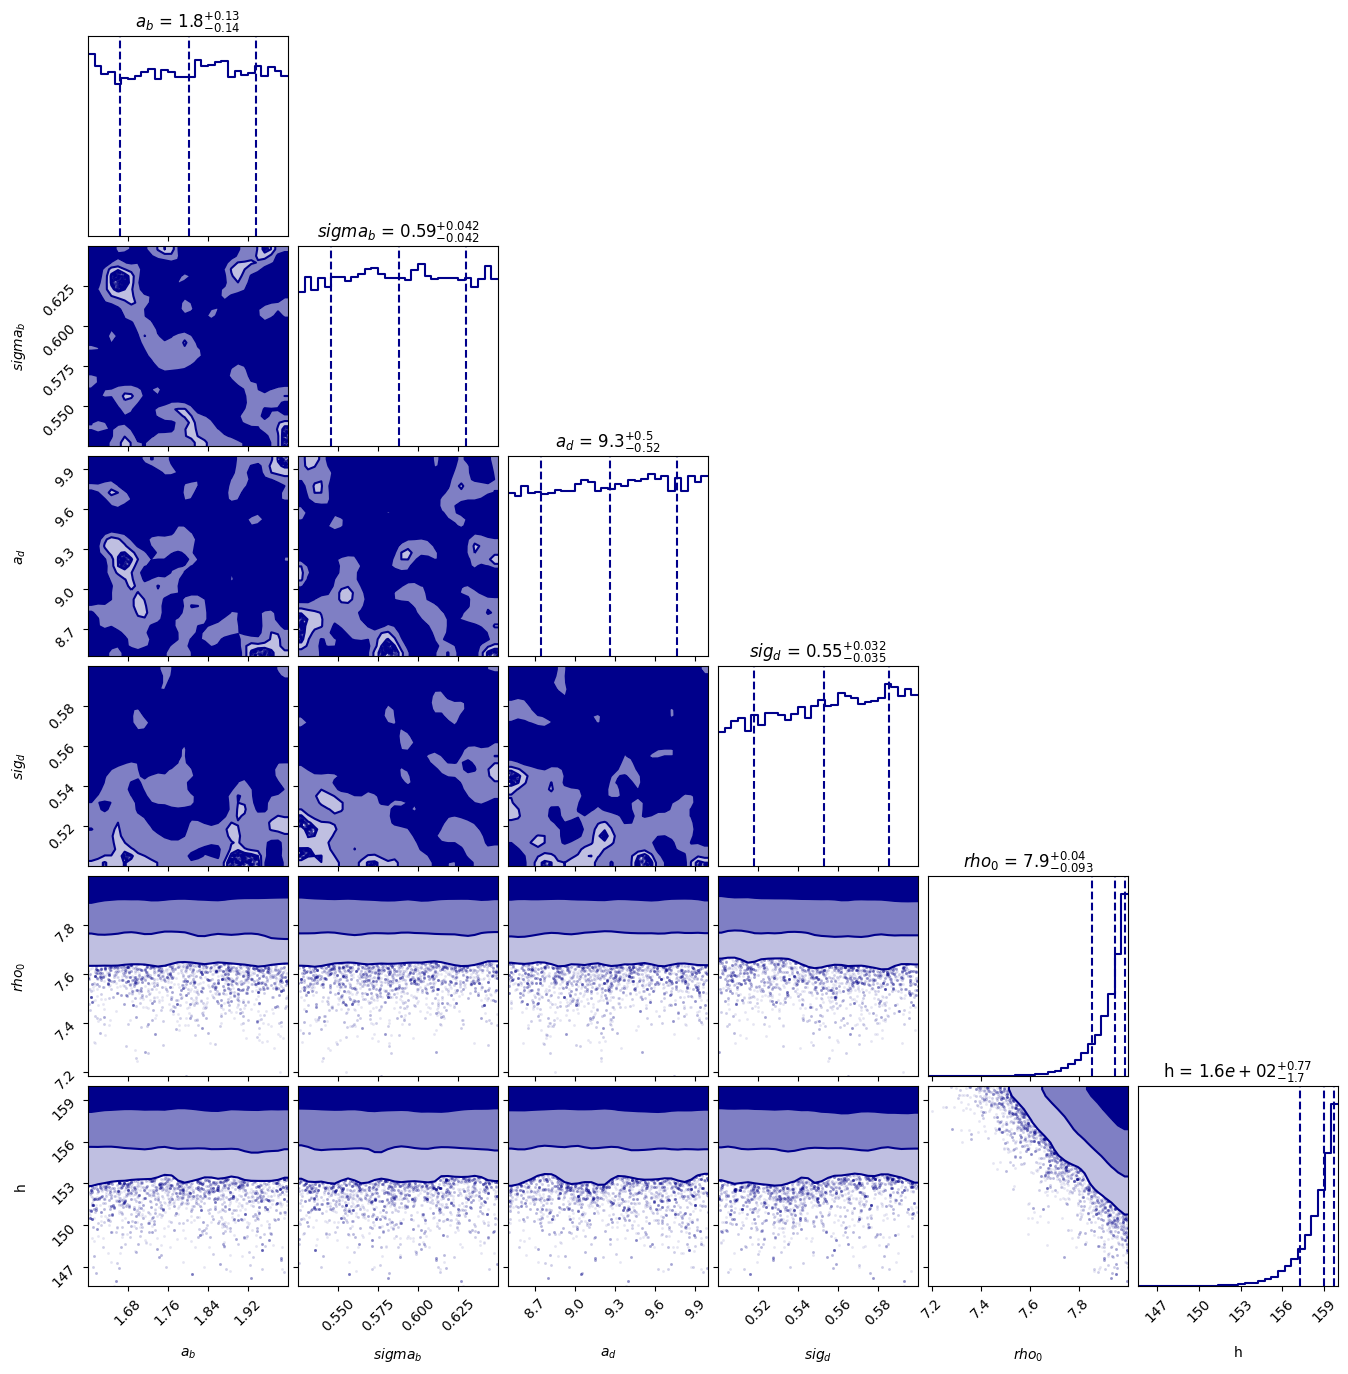

In [25]:
import corner 
fig = corner.corner(flat_samples,bins=30,labels=["$a_b$","$sigma_b$","$a_d$" , "$sig_d$", "$rho_0$", "h"],
                    color="darkblue",
                    quantiles=[0.16, 0.5, 0.84],                     # default value
                    plot_contours=True,
                    fill_contours=True,
                    levels=(0.68,0.95,0.99,),
                    plot_datapoints=True,
                    smooth=True, smooth1d=False,
                    title_fmt=".2g",                    # .2f  or  .2g
                    show_titles=True,
                    )